# This is a notebook of fuzzy architecture used in the final project

The title of this research is "Decision Support System for Environmental Condition Analysis in Mobile-Based Hydroponic Gardens Using Fuzzy Logic" where the fuzzy used is the Takagi-Sugeno-kang method or often also called Sugeno.

In [15]:
import numpy as np


def explode_array(arr):
    """Explode array into int s"""
    return [float(i) for i in np.array(arr).flatten()]


def membership_function(x, params):
    """
    Fungsi keanggotaan generik untuk segitiga dan trapezium.
    params: (a, b, c) untuk segitiga, (a, b, c, d) untuk trapezium.
    """
    if len(params) == 3:  # Segitiga
        a, b, c = explode_array(params)
        return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)
    elif len(params) == 4:  # Trapezium
        a, b, c, d = explode_array(params)
        return np.maximum(np.minimum(np.minimum((x - a) / (b - a), 1), (d - x) / (d - c)), 0)


# Variabel linguistik
x_ph = np.linspace(0, 14, 2000)
x_tds = np.linspace(0, 2500, 2000)
x_temp = np.linspace(0, 45, 2000)

# Define ranges for each linguistic variable
ph_ranges = {
    "Asam": [0, 0, 6, 7],
    "Optimal": [6, 6.5, 7],
    "Basa": [7, 8, 14, 14]
}

tds_ranges = {
    "Sangat Rendah": [0, 0, 400, 600],
    "Rendah": [400, 600, 900, 1100],
    "Optimal": [900, 1100, 1800, 2000],
    "Tinggi": [1800, 2000, 2500, 2500]
}

temp_ranges = {
    "Dingin": [0, 0, 23, 25],
    "Optimal": [24, 27, 30],
    "Panas": [28, 30, 45, 45]
}

# Keanggotaan pH
ph_acidic = membership_function(x_ph, explode_array(ph_ranges["Asam"]))
ph_neutral = membership_function(x_ph, explode_array(ph_ranges["Optimal"]))
ph_alkali = membership_function(x_ph, explode_array(ph_ranges["Basa"]))

# Keanggotaan TDS
tds_lowest = membership_function(x_tds, explode_array(tds_ranges["Sangat Rendah"]))
tds_low = membership_function(x_tds, explode_array(tds_ranges["Rendah"]))
tds_medium = membership_function(x_tds, explode_array(tds_ranges["Optimal"]))
tds_high = membership_function(x_tds, explode_array(tds_ranges["Tinggi"]))

# Keanggotaan Suhu
temp_cold = membership_function(x_temp, explode_array(temp_ranges["Dingin"]))
temp_normal = membership_function(x_temp, explode_array(temp_ranges["Optimal"]))
temp_hot = membership_function(x_temp, explode_array(temp_ranges["Panas"]))

/var/folders/1g/c081dqj91qb8hsn4k3vl9sjr0000gn/T/ipykernel_91714/2338848257.py:19: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(np.minimum(np.minimum((x - a) / (b - a), 1), (d - x) / (d - c)), 0)
/var/folders/1g/c081dqj91qb8hsn4k3vl9sjr0000gn/T/ipykernel_91714/2338848257.py:19: RuntimeWarning: invalid value encountered in divide
  return np.maximum(np.minimum(np.minimum((x - a) / (b - a), 1), (d - x) / (d - c)), 0)


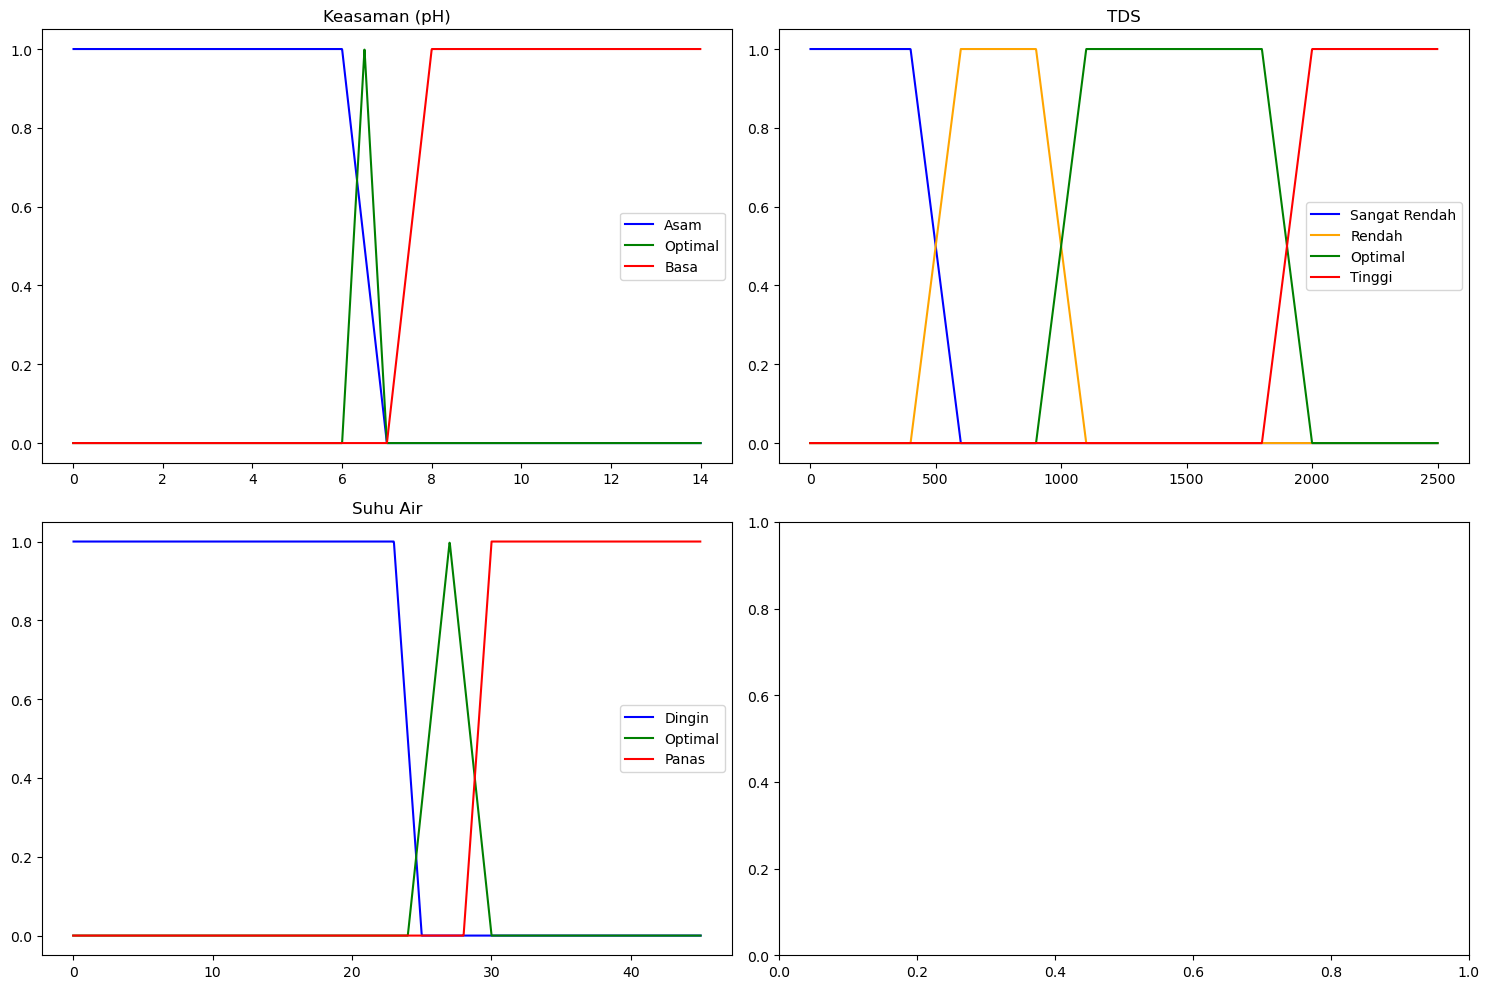

In [16]:
import matplotlib.pyplot as plt

# Plot keanggotaan
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(x_ph, ph_acidic, label='Asam', color='blue')
axs[0, 0].plot(x_ph, ph_neutral, label='Optimal', color='green')
axs[0, 0].plot(x_ph, ph_alkali, label='Basa', color='red')
axs[0, 0].set_title('Keasaman (pH)')
axs[0, 0].legend()

axs[0, 1].plot(x_tds, tds_lowest, label='Sangat Rendah', color='blue')
axs[0, 1].plot(x_tds, tds_low, label='Rendah', color='orange')
axs[0, 1].plot(x_tds, tds_medium, label='Optimal', color='green')
axs[0, 1].plot(x_tds, tds_high, label='Tinggi', color='red')
axs[0, 1].set_title('TDS')
axs[0, 1].legend()

axs[1, 0].plot(x_temp, temp_cold, label='Dingin', color='blue')
axs[1, 0].plot(x_temp, temp_normal, label='Optimal', color='green')
axs[1, 0].plot(x_temp, temp_hot, label='Panas', color='red')
axs[1, 0].set_title('Suhu Air')
axs[1, 0].legend()

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

# Load data
file_path = 'data/monitoring_logs_2024-12-11.csv'
data = pd.read_csv(file_path)


# Fungsi aturan fuzzy dan defuzzifikasi
def fuzzy_rules(x1, x2, x3):
    """
    Aturan fuzzy: Mengembalikan firing strength untuk kondisi di mana semua input bernilai Medium.
    """
    # Output 1 jika semua sensor berada pada kategori Medium
    if "Optimal" in x1 and "Optimal" in x2 and "Optimal" in x3:
        return [{"firing_strength": min(x1["Optimal"], x2["Optimal"], x3["Optimal"]), "output": 1}]

    # Jika kondisi tidak terpenuhi, firing strength adalah 0
    return [{"firing_strength": 0, "output": 0}]


def defuzzification(rules):
    """Defuzzifikasi dengan metode Sugeno (Weighted Average)"""
    numerator = sum(rule["firing_strength"] * rule["output"] for rule in rules)
    denominator = sum(rule["firing_strength"] for rule in rules)

    if denominator == 0:
        return 0  # Nilai default jika semua firing strength nol

    return numerator / denominator


def fungsi_segitiga(x, params):
    a, b, c = [np.array(p) for p in params]

    if x <= a or x >= c:
        return 0.0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x < c:
        return (c - x) / (c - b)
    return 0.0


def fungsi_trapezium(x, params):
    a, b, c, d = [np.array(p) for p in params]

    if x <= a or x >= d:
        return 0.0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x <= c:
        return 1.0
    elif c < x < d:
        return (d - x) / (d - c)
    return 0.0


def ph_membership(x):
    return {
        "Asam": fungsi_trapezium(x, explode_array(ph_ranges["Asam"])),
        "Optimal": fungsi_segitiga(x, explode_array(ph_ranges["Optimal"])),
        "Basa": fungsi_trapezium(x, explode_array(ph_ranges["Basa"]))
    }


def tds_membership(x):
    return {
        "Sangat Rendah": fungsi_trapezium(x, explode_array(tds_ranges["Sangat Rendah"])),
        "Rendah": fungsi_trapezium(x, explode_array(tds_ranges["Rendah"])),
        "Optimal": fungsi_trapezium(x, explode_array(tds_ranges["Optimal"])),
        "Tinggi": fungsi_trapezium(x, explode_array(tds_ranges["Tinggi"]))
    }


def temp_membership(x):
    return {
        "Dingin": fungsi_trapezium(x, explode_array(temp_ranges["Dingin"])),
        "Optimal": fungsi_segitiga(x, explode_array(temp_ranges["Optimal"])),
        "Panas": fungsi_trapezium(x, explode_array(temp_ranges["Panas"]))
    }


# Fungsi untuk mengevaluasi output fuzzy
def fuzzy_output(row):
    x1 = row['ph']
    x2 = row['tank_tds']
    x3 = row['water_temp']

    # Tentukan keanggotaan
    ph_mf = ph_membership(x1)
    tds_mf = tds_membership(x2)
    temp_mf = temp_membership(x3)

    rules = fuzzy_rules(ph_mf, tds_mf, temp_mf)
    return defuzzification(rules).__ceil__()


# test with single data
ph = 6.8
tds = 1100
temp = 25

ph_result = ph_membership(ph)
tds_result = tds_membership(tds)
temp_result = temp_membership(temp)

rule_result = fuzzy_rules(ph_result, tds_result, temp_result)

print('ph:', ph_result)
print('tds:', tds_result)
print('temp:', temp_result)

print('ph category:', max(ph_result, key=ph_result.get))
print('tds category:', max(tds_result, key=tds_result.get))
print('temp category:', max(temp_result, key=temp_result.get))

output = defuzzification(rule_result)

print(output)

# Tambahkan kolom kategori pH, TDS, dan Suhu
# data['pH_Range'] = data['ph'].apply(lambda x: max(ph_membership(x), key=ph_membership(x).get))
# data['TDS_Range'] = data['tank_tds'].apply(lambda x: max(tds_membership(x), key=tds_membership(x).get))
# data['Temp_Range'] = data['water_temp'].apply(lambda x: max(temp_membership(x), key=temp_membership(x).get))

# Tambahkan kolom output fuzzy
# data['Fuzzy_Output'] = data.apply(fuzzy_output, axis=1)
# data.head()

ph: {'Asam': 0.20000000000000018, 'Optimal': 0.40000000000000036, 'Basa': 0.0}
tds: {'Sangat Rendah': 0.0, 'Rendah': 0.0, 'Optimal': 1.0, 'Tinggi': 0.0}
temp: {'Dingin': 0.0, 'Optimal': 0.3333333333333333, 'Panas': 0.0}
ph category: Optimal
tds category: Optimal
temp category: Optimal
1.0
